In [84]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import fastmri
from fastmri.data import transforms as T
from fastmri.data.subsample import RandomMaskFunc, EquiSpacedMaskFunc


In [85]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [86]:
hf =  h5py.File(r'D:\Class Project\209\brain_multicoil_train_batch_1\file_brain_AXFLAIR_200_6002442.h5', 'r')
print(list(hf.keys()))
#mask = hf['mask'][:]  # Load the mask
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

header = hf['ismrmrd_header'][()]  # Load the header data

print(header)

#print("Mask shape:", mask.shape)
print("K_Space shape:", volume_kspace.shape)

['ismrmrd_header', 'kspace', 'reconstruction_rss']
complex64
(16, 16, 640, 320)
b'<?xml version="1.0" encoding="utf-8"?>\n<ismrmrdHeader xmlns="http://www.ismrm.org/ISMRMRD" xmlns:xs="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.ismrm.org/ISMRMRD ismrmrd.xsd">\n   <studyInformation>\n      <studyTime>12:51:14</studyTime>\n   </studyInformation>\n   <measurementInformation>\n      <measurementID>45219_140956920_140956929_257</measurementID>\n      <patientPosition>HFS</patientPosition>\n      <protocolName>AX FLAIR_FBB</protocolName>\n      <frameOfReferenceUID>1.3.12.2.1107.5.2.19.45219.1.20190616124032185.0.0.4986</frameOfReferenceUID>\n   </measurementInformation>\n   <acquisitionSystemInformation>\n      <systemVendor>SIEMENS</systemVendor>\n      <systemModel>Skyra</systemModel>\n      <systemFieldStrength_T>2.8936</systemFieldStrength_T>\n      <relativeReceiverNoiseBandwidth>0.793</relativeReceiverNoiseBand

In [87]:
slice_kspace = volume_kspace[0] # Choosing the 20-th slice of this volume

In [88]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

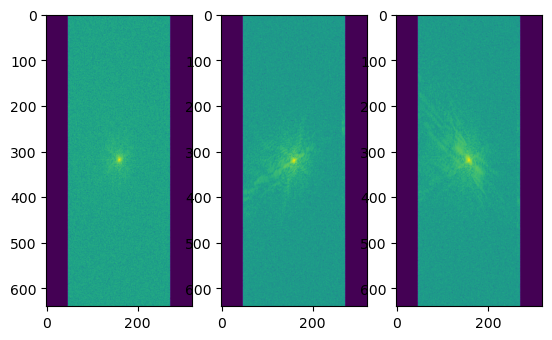

In [89]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10


In [90]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

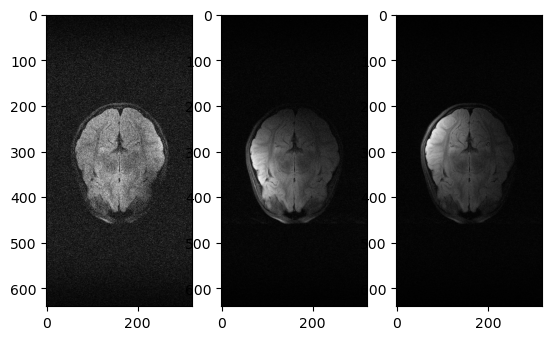

In [91]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')


In [92]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)


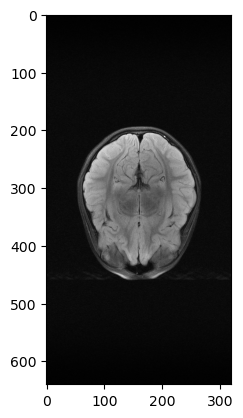

In [93]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')


In [94]:
mask_func = EquiSpacedMaskFunc(center_fractions=[0.08], accelerations=[20])  # Create the mask function object
masked_kspace, mask_new, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space


In [95]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

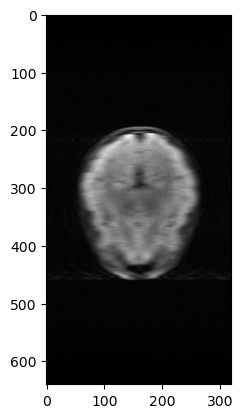

In [96]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')


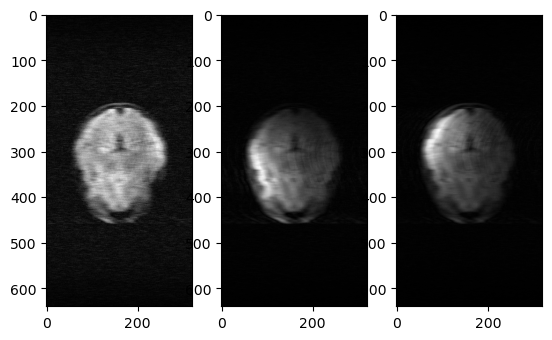

In [97]:
show_coils(sampled_image_abs, [0, 5, 10], cmap='gray')

In [98]:
def create_2d_cartesian_mask(shape, acceleration_factor=4, center_fraction=0.1):
    """Create a custom 2D Cartesian undersampling mask."""
    # shape: (height, width) of the k-space data (e.g., (640, 320))
    mask = np.zeros(shape)
    
    # Create central fully-sampled region
    num_center_lines_y = int(center_fraction * shape[0])
    num_center_lines_x = int(center_fraction * shape[1])
    mask[(shape[0] // 2 - num_center_lines_y // 2):(shape[0] // 2 + num_center_lines_y // 2),
         (shape[1] // 2 - num_center_lines_x // 2):(shape[1] // 2 + num_center_lines_x // 2)] = 1
    
    # Randomly sample the remaining points
    remaining_samples = int(shape[0] * shape[1] / acceleration_factor)
    sampled_indices = np.random.choice(np.arange(mask.size), remaining_samples, replace=False)
    mask.flat[sampled_indices] = 1
    
    return mask

In [99]:
kspace_shape = (640, 320)
mask_2d = create_2d_cartesian_mask(kspace_shape, acceleration_factor=6, center_fraction=0.05)


In [100]:
def apply_custom_mask(kspace, mask):
    """Apply a custom mask to k-space data."""
    return kspace * mask

In [101]:
# Load the k-space data (assuming it's loaded into the variable `kspace`)
# Apply the custom 2D Cartesian mask
mask_2d_broadcasted = np.broadcast_to(mask_2d, (16, 640, 320,2))

# Apply the mask to the k-space data
masked_kspace = slice_kspace2 * mask_2d_broadcasted


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (640,320)  and requested shape (16,640,320,2)